**Load the Libraries**

In [56]:
import os
import math
import pandas as pd
import networkx as nx
import cv2
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

**Load the Dataset**

In [ ]:
df = pd.read_csv("/content/fraudTrain.csv")
df = df[df["is_fraud"]==0].sample(frac=0.20, random_state=42).append(df[df["is_fraud"] == 1])
df.head(50)

**Data intuition**

In [ ]:
df.info()

**Analysis of transaction with respect to each Category**

In [ ]:
cat =df.groupby(['category'])['category'].count().reset_index(name='counts')
print(cat)

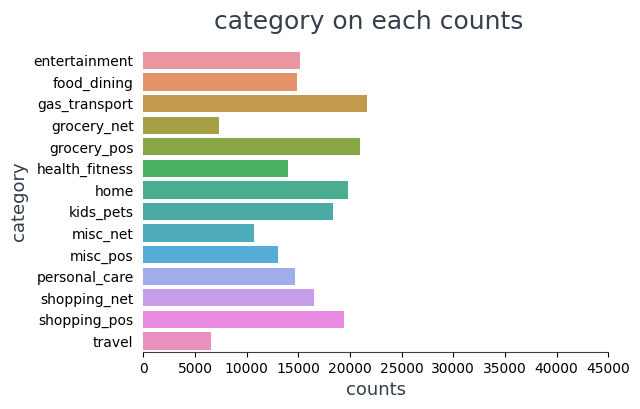

In [62]:
# set figure size and dpi
fig, ax = plt.subplots(figsize=(6,4), dpi=100)

# add colors to xticks, yticks and edge
plt.rcParams['axes.edgecolor']='#333F4B'

# customize spines and tick parameters
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(axis='both', which='both', labelsize=10, bottom=True, left=False)
ax.set_xlim(0,45000)
# remove grid and set background color
ax.grid(False)
ax.set_facecolor('white')

# plot the data
sns.barplot(data=cat, x='counts', y='category');

# set x and y-axis labels and title
ax.set_xlabel('counts', fontsize=13, color = '#333F4B')
ax.set_ylabel('category', fontsize=13, color = '#333F4B')
fig.suptitle('category on each counts',fontsize=18, color = '#333F4B');

**Target Variable distribution**


In [7]:
df["is_fraud"].value_counts()

0.0    207226
1.0      5981
Name: is_fraud, dtype: int64

**Data Preparation - Creating Graph Nodes and Edges from DataFrame**

In [8]:
def build_graph_bipartite (df_input, graph_type=nx.Graph()):
 df = df_input.copy()
 mapping = {x:node_id for node_id,x in enumerate(set (df ["cc_num"].values.tolist() + df["merchant"].values.tolist()))}
 df["from"] = df ["cc_num"].apply(lambda x: mapping[x])
 df["to"] = df["merchant"].apply(lambda x: mapping[x]) 
 df = df[['from', 'to', "amt", "is_fraud"]].groupby(['from', 'to']).agg({"is_fraud": "sum", "amt": "sum"}).reset_index()
 df["is_fraud"]=df["is_fraud"].apply(lambda x: 1 if x>0 else 0)

 G = nx.from_edgelist (df[["from", "to"]].values, create_using=graph_type)

 nx.set_node_attributes (G, {x:1 for x in df["from"].unique()}, "bipartite")
 nx.set_node_attributes (G, {x:2 for x in df["to"].unique()}, "bipartite")

 nx.set_edge_attributes(G,{(int(x["from"]), int(x["to"])):x["is_fraud"] for idx, x in df[["from","to","is_fraud"]].iterrows()}, "label")

 nx.set_edge_attributes(G,{(int(x["from"]), int(x["to"])):x["amt"] for idx, x in df[["from", "to", "amt"]].iterrows()}, "weight")

 return G

In [9]:
G_bu = build_graph_bipartite (df, nx.Graph (name='Bipartite Undirected'))
G_bd = build_graph_bipartite (df, nx.DiGraph (name='Bipartite Directed'))



In [10]:
from networkx.algorithms import bipartite
bipartite.is_bipartite(G_bu)


True

**Statistical Analysis**

In [11]:
print(nx.info(G_bu))


Graph with 1658 nodes and 170274 edges


**Nodes Degree distribution**

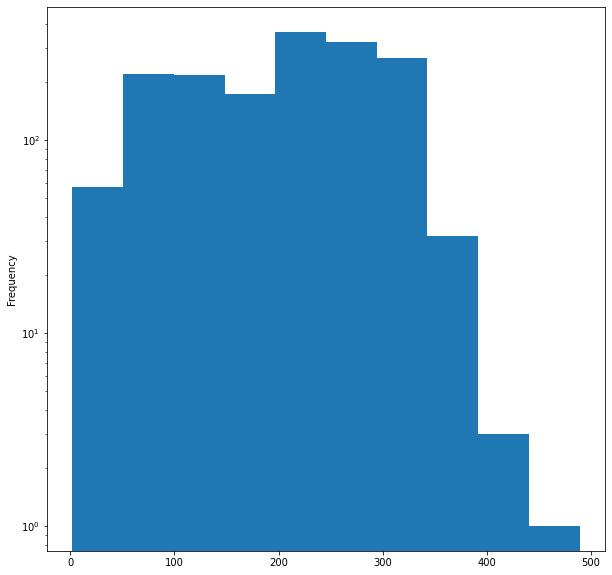

In [12]:
for G in [G_bu]:
  plt.figure(figsize=(10,10))
  degrees = pd.Series(
      {
        k:v for k,v in nx.degree (G)
      }
  )
  degrees.plot.hist()
  plt.yscale("log")

**Closeness Centrality**

In [ ]:
nx.closeness_centrality(G_bu)

**Degree Centrality**

In [ ]:
nx.degree_centrality(G_bu)

**Community Detection & Fraudulent Edges Ratio Analysis**

In [22]:
import community.community_louvain as cl

In [69]:
parts = cl.best_partition(G_bu, random_state=42, weight='weight')
communities = pd.Series(parts) 
communities.value_counts().sort_values (ascending=False)


4     580
2     128
5     111
1     102
7      92
15     88
8      84
14     83
11     78
9      72
10     54
12     54
0      52
13     36
3      31
6      13
dtype: int64

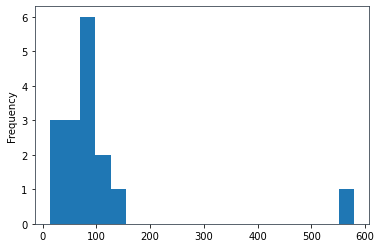

In [70]:
communities.value_counts().plot.hist(bins=20);

In [24]:
graphs = []
d = {}
for x in communities.unique():
  tmp = nx.subgraph (G_bu, communities [communities==x].index)
  fraud_edges=sum(nx.get_edge_attributes (tmp, "label").values())
  ratio = 0 if fraud_edges == 0 else (fraud_edges/tmp.number_of_edges())*100
  d[x] = ratio
  graphs += [tmp]
pd.Series (d).sort_values (ascending=False)

11    22.670025
12    21.739130
0     21.256039
5     18.685567
7     17.973231
9     17.391304
10    17.021277
2     15.768057
14    14.587738
8     13.246269
6     11.538462
3     10.638298
13    10.526316
1      8.343126
4      1.565530
15     1.050420
dtype: float64

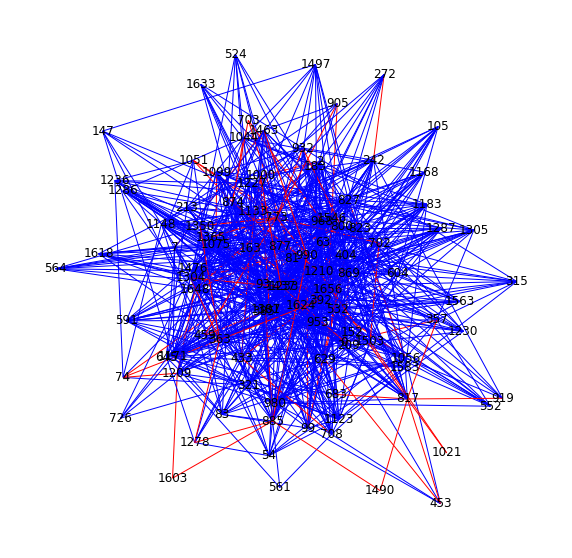

In [66]:
gId = 1
plt.figure(figsize=(10,10))
spring_pos = nx.spring_layout(graphs[gId])
plt.axis("off")
edge_colors = ["r" if x == 1 else "b" for x in nx.get_edge_attributes(graphs [gId], 'label').values()]
default_node_color = ["r" if x == 1 else "b" for x in nx.get_node_attributes(graphs [gId], 'label').values()]
nx.draw_networkx(graphs[gId], pos=spring_pos, node_color=default_node_color,
                 edge_color=edge_colors, with_labels=True, node_size=15)

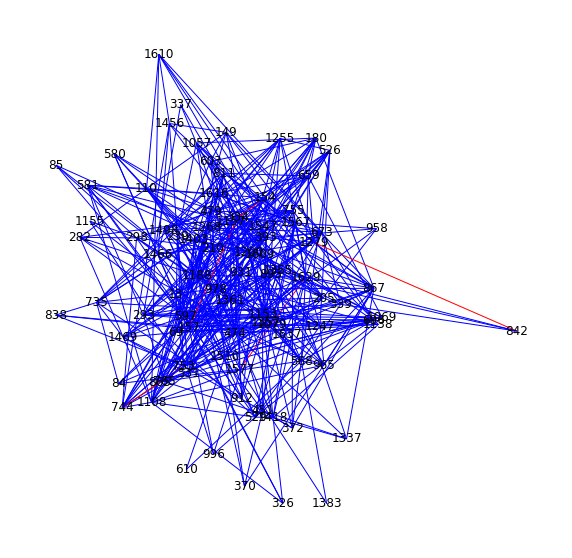

In [67]:
gId = 15
plt.figure(figsize=(10,10))
spring_pos = nx.spring_layout(graphs[gId])
plt.axis("off")
edge_colors = ["r" if x == 1 else "b" for x in nx.get_edge_attributes(graphs [gId], 'label').values()]
default_node_color = ["r" if x == 1 else "b" for x in nx.get_node_attributes(graphs [gId], 'label').values()]
nx.draw_networkx(graphs[gId], pos=spring_pos, node_color=default_node_color,
                 edge_color=edge_colors, with_labels=True, node_size=15)

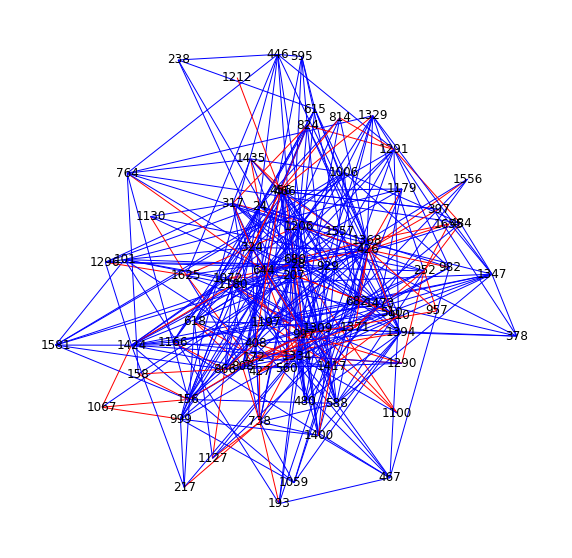

In [68]:
gId = 11
plt.figure(figsize=(10,10))
spring_pos = nx.spring_layout(graphs[gId])
plt.axis("off")
edge_colors = ["r" if x == 1 else "b" for x in nx.get_edge_attributes(graphs [gId], 'label').values()]
default_node_color = ["r" if x == 1 else "b" for x in nx.get_node_attributes(graphs [gId], 'label').values()]
nx.draw_networkx(graphs[gId], pos=spring_pos, node_color=default_node_color,
                 edge_color=edge_colors, with_labels=True, node_size=15)